# Calculate Effective Area

In this example we will calculate the effective area of a detector over a range of energies.

### WARNING:
In order to finish reasonably quickly, the number of events thrown in this example is low. This means that there are likely not enough events to accurately represent the effective area of the detector. For an accurate measurement, the number of events must be increased, but this will need much more time to run in that case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyrex
import pyrex.custom.ara as ara

First let's set the number of events that we will be throwing at each energy, and the energies we will be using. As stated in the warning, the number of events is set low to speed up the example, but that means the results are likely inaccurate.

In [2]:
n_events = 10
energies = [1e8, 1e9, 1e10] # GeV

Next, set up the detector to be measured. Here we use a single standard ARA station.

In [3]:
detector = ara.HexagonalGrid(station_type=ara.RegularStation,
                             stations=1)
detector.build_antennas(power_threshold=-6.15)

Now set up a neutrino generator for each energy. Let's scale the generation volume by energy so that we're not wasting too much time generating neutrinos that will surely never trigger.

In [4]:
dimensions = [2500, 5000, 10000]
generators = [pyrex.ShadowGenerator(dx=2*dim, dy=2*dim, dz=2800, energy=energy)
              for energy, dim in zip(energies, dimensions)]

And then set up the event kernels for each energy. Let's use the ArasimIce class as our ice model since it calculates attenuations faster at the loss of some accuracy.

In [5]:
kernels = [pyrex.EventKernel(generator=gen, antennas=detector,
                             ice_model=pyrex.ice_model.ArasimIce)
           for gen in generators]

Now run each kernel and record the number of events from each that triggered the detector. In this case we'll set our trigger condition to 3/8 antennas triggering in a single polarization.

In [6]:
triggers = np.zeros(len(energies))
for i, kernel in enumerate(kernels):
    print("Running energy", energies[i])
    for j in range(n_events):
        print(j, "..", sep="", end="")
        detector.clear(reset_noise=True)
        particle = kernel.event()
        triggered = detector.triggered(station_requirement=1,
                                       polarized_antenna_requirement=3)
        if triggered:
            triggers[i] += 1
            print("y", end=" ")
        else:
            print("n", end=" ")
        
        if j%10==9:
            print(flush=True)
print("Done")

Running energy 100000000.0
0..n 1..n 2..n 3..n 4..n 5..n 6..n 7..n 8..n 9..n 
Running energy 1000000000.0
0..n 1..n 2..y 3..n 4..n 5..n 6..n 7..n 8..n 9..n 
Running energy 10000000000.0
0..n 1..n 2..n 3..n 4..n 5..n 6..n 7..n 8..n 9..n 
Done


Now that we have the trigger counts for each energy, we can calculate the effective volumes by scaling the trigger probability by the generation volume. Errors are calculated assuming poisson counting statistics.

In [7]:
generation_volumes = np.array([(2*dim)*(2*dim)*2800 for dim in dimensions])
effective_volumes = triggers / n_events * generation_volumes
volume_errors = np.sqrt(triggers) / n_events * generation_volumes

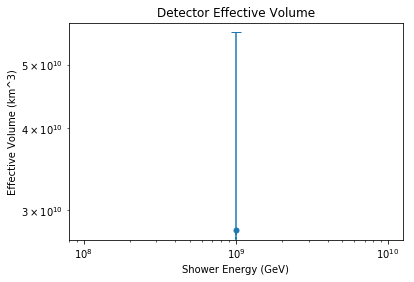

In [8]:
plt.errorbar(energies, effective_volumes, yerr=volume_errors,
             marker="o", markersize=5, linestyle=":", capsize=5)
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.title("Detector Effective Volume")
plt.xlabel("Shower Energy (GeV)")
plt.ylabel("Effective Volume (km^3)")
plt.show()

Then from the effecitve volumes, we can calculate the effective areas. First we need to account for the fact that our energy is the shower energy and convert to the neutrino energy. Then the effective area is the probability of interaction in the ice volume times the effective volume. The probability of interaction in the ice volume is given by the interaction cross section times the density of the ice. Since the neutrino type is not specified in the simulation, calculate the cross section as a weighted average of neutrino cross sections.

In [9]:
nu_energies = 9/5*np.array(energies)
ice_density = 0.92 # g/cm^3
ice_density *= 1e15 # converted to g/km^3 = nucleons/km^3
cross_sections = (pyrex.particle.CC_NU.cross_section(nu_energies) +
                  3*pyrex.particle.NC_NU.cross_section(nu_energies) +
                  pyrex.particle.CC_NUBAR.cross_section(nu_energies) +
                  3*pyrex.particle.NC_NUBAR.cross_section(nu_energies)) / 8
effective_areas = 6.022e23 * ice_density * cross_sections * effective_volumes
effective_areas *= 1e-4 # converted from cm^2 to m^2
area_errors = 6.022e23 * ice_density * cross_sections * volume_errors

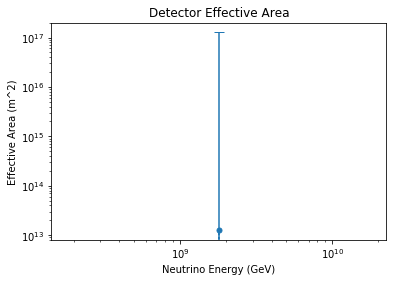

In [10]:
plt.errorbar(nu_energies, effective_areas, area_errors,
             marker="o", markersize=5, linestyle=":", capsize=5)
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.title("Detector Effective Area")
plt.xlabel("Neutrino Energy (GeV)")
plt.ylabel("Effective Area (m^2)")
plt.show()